# Denoising Transformer

**Reference:**

D. Chen, W. Hong and X. Zhou, "Transformer Network for Remaining Useful Life Prediction of Lithium-Ion Batteries," in IEEE Access, vol. 10, pp. 19621-19628, 2022.

**Based on their code hosted on Github:**

https://github.com/XiuzeZhou/RUL

Check if you have NVIDIA GPU:

In [ ]:
!nvidia-smi

Tue Jan  3 10:21:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Preparing Datasets and Packages

In [ ]:
# If LOAD_NPY = True, npy file will be loaded instead of .mat files
LOAD_NPY = True

# import packages
import shutil
from google.colab import drive

# mount drive
drive.mount('/content/drive', force_remount=True)

if LOAD_NPY:
  dest = '/content/'                                      # this is in the colab VM
  drive_src = '/content/drive/MyDrive/datasets/NASA/'     # location from GDrive (folder)
  src = drive_src + "NASA.npy"                            # Specify file name
  print(f"Copying {src} to {dest}")                       
  shutil.copy(src,dest)                                   # Copy to dest
else:
  # create folder for destination path
  from pathlib import Path
  Path("datasets/NASA/").mkdir(parents=True, exist_ok=True)

  # define paths
  dest = '/content/datasets/NASA/'                        # this is in the colab VM
  drive_src = '/content/drive/MyDrive/datasets/NASA/'     # location from GDrive (folder)

  # copy to dest
  for filename in ['B0005.mat', 'B0006.mat', 'B0007.mat', 'B0018.mat']:
    src = drive_src + filename
    print(f"Copying {src} to {dest}")
    shutil.copy(src,dest)

Mounted at /content/drive
Copying /content/drive/MyDrive/datasets/NASA/NASA.npy to /content/


Install the following packages (if on Colab)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.5 MB/s eta 0:00:00


## Import Packages

In [ ]:
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
import pathlib
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from tqdm.auto import tqdm

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Data Processing

In [ ]:
# convert str to datatime 
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data.append(d1)

    return data


# get capacity data
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]


# get the charge data of a battery
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

In [ ]:
Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = 'datasets/NASA/'

if LOAD_NPY:
  # If the original data set cannot be read successfully, you can simply load the data already extracted: NASA.npy
  Battery = np.load('NASA.npy', allow_pickle=True)
  Battery = Battery.item()
else:
  Battery = {}
  for name in Battery_list:
      print('Load Dataset ' + name + '.mat ...')
      path = dir_path + name + '.mat'
      data = loadMat(path)
      Battery[name] = getBatteryCapacity(data)
  np.save('datasets/NASA/NASA.npy', Battery, allow_pickle=True)

### Plot the dataset

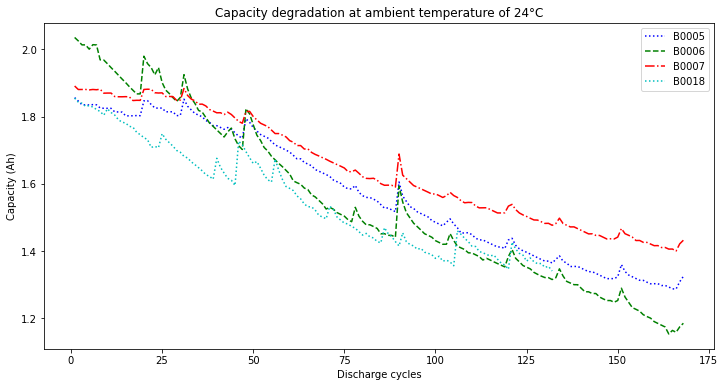

In [ ]:
fig, ax = plt.subplots(1, figsize=(12, 6))
color_list = ['b:', 'g--', 'r-.', 'c:']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()
plt.savefig("NASA_Capacity_Degradation.svg")

## Functions for building the data sequences

In [ ]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


def split_dataset(data_sequence, train_ratio=0.0, capacity_threshold=0.0):
    if capacity_threshold > 0:
        max_capacity = max(data_sequence)
        capacity = max_capacity * capacity_threshold
        point = [i for i in range(len(data_sequence)) if data_sequence[i] < capacity]
    else:
        point = int(train_ratio + 1)
        if 0 < train_ratio <= 1:
            point = int(len(data_sequence) * train_ratio)
    train_data, test_data = data_sequence[:point], data_sequence[point:]
    return train_data, test_data


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) 
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## Model Declaration

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01):
        super(Autoencoder, self).__init__()
        self.input_size, self.hidden_dim, self.noise_level = input_size, hidden_dim, noise_level
        self.fc1 = nn.Linear(self.input_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.input_size)
        
    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1
    
    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x
    
    def decoder(self, x):
        h2 = self.fc2(x)
        return h2
    
    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode
    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.0, max_len=16):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :].squeeze(1)
        return x


class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, num_layers=1, nhead=8, dropout=0.0, noise_level=0.01):
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size/2)
        input_size = self.auto_hidden 
        self.pos = PositionalEncoding(d_model=input_size, max_len=input_size)
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.linear = nn.Linear(input_size, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)
 
    def forward(self, x): 
        batch_size, feature_num, feature_size  = x.shape 
        encode, decode = self.autoencoder(x.reshape(batch_size, -1))# batch_size*seq_len
        out = encode.reshape(batch_size, -1, self.auto_hidden)
        out = self.pos(out)
        out = out.reshape(1, batch_size, -1) # (1, batch_size, feature_size)
        out = self.cell(out)  
        out = out.reshape(batch_size, -1) # (batch_size, hidden_dim)
        out = self.linear(out)            # out shape: (batch_size, 1)
        
        return out, decode

## Model Training

### Defining functions for training

In [ ]:
def train_step(model: torch.nn.Module,
               train_x: np.array,
               train_y: np.array,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  '''
  Performs training on a model.
  '''
  # put model in training mode
  model.train()

  X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32) # (batch_size, seq_len, input_size)
  y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)          # (batch_size, 1)

  X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)

  # Forward pass
  y_pred, decode = model(X)

  # Reshape y_pred
  y_pred = y_pred.reshape(-1, 1)

  loss = loss_fn(y_pred, y) + alpha * loss_fn(decode, X.reshape(-1, feature_size))

  # clear gradients for this training step
  optimizer.zero_grad()

  # backpropagation, compute gradients              
  loss.backward()  

  # apply gradients            
  optimizer.step()   

  return loss 

In [ ]:
def test_step(model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              train_data: list,
              test_data: list,
              device: torch.device = device):   
  """
    Performs a testing loop step on model going over data_loader
  """
  y_ = []
  model.eval()
  with torch.inference_mode():
    test_x = train_data.copy() 
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
        x = torch.from_numpy(x).to(device)   # shape (batch_size,feature_size=1,input_size)
        pred, _ = model(x)                   # pred shape: (batch_size=1, feature_size=1)
        next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
        test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
        point_list.append(next_point)  # Saves the predicted value of the last point in the output sequence
    y_.append(point_list)              # Save all the predicted values

    rmse = evaluation(y_test=test_data, y_predict=y_[-1])
    re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)

    return rmse, re

In [ ]:
def train_model(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, seed=0, 
                alpha=0.0, noise_level=0.0, dropout=0.0, metric='re', is_load_weights=True,
                leave_out = ['B0007'], device=device):
  
  # Define which batteries to train on
  train_list = Battery_list.copy()

  for entry in [leave_out]:
    train_list.pop(train_list.index(entry))

  # Setup seed
  setup_seed(seed)
  # define window size
  window_size = feature_size

  # Declare the model
  model = Net(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, dropout=dropout,
              noise_level=noise_level)
  
  # send model to device
  model = model.to(device)
  # Declare optimizer and criterion (loss function)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = nn.MSELoss()  
  #criterion = nn.HuberLoss()

  # load the weights if True
  if is_load_weights:
    checkpoint = f'transformer_NASA_{leave_out}.pth'
    model.load_state_dict(torch.load(checkpoint))
    print(f"loaded {checkpoint}")    
  else:
    print("Training model from scratch.")

  # Create dictionary for training data
  train_dict = {}
  for name in train_list:
    train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
    train_dict[name] = train_x, train_y, train_data, test_data

  # training loop
  loss_list = []
  for epoch in tqdm(range(EPOCH)):
    for name in train_list:
      train_x, train_y, train_data, test_data = train_dict[name]
      loss = train_step(model=model, train_x=train_x, train_y=train_y, loss_fn=criterion,
                        optimizer=optimizer,device=device)
      loss_list.append(loss)
      
      if (epoch+1)%300 == 0:
        rmse, re = test_step(model=model, loss_fn=criterion, 
                             train_data=train_data, test_data=test_data,
                             device=device)
        print(f'({name}) epoch:{epoch:<2d} | loss:{loss:<6.4f} | RMSE:{rmse:<6.4f} | RE:{re:<6.4f}')

  return model

### Training Loop
**Grid search results:**

**optimal parameters for offline device : Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, Win10**

Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 2000
nhead = 8
hidden_dim = 16
num_layers = 1
lr = 0.01    # learning rate
weight_decay = 0.0
noise_level = 0.0
alpha = 1e-5
metric = 're'
re mean: 0.2082

Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 2000
nhead = 8
hidden_dim = 16
num_layers = 1
lr = 0.0001    # learning rate
weight_decay = 1e-5
noise_level = 0.0
alpha = 2e-3
metric = 'rmse'
rmse mean: 0.0806

**Optimal parameters for Google Colab: NVIDIA Tesla T4 GPU**

lr=0.01, num_layers=2, hidden_dim=32, alpha=0.0001, re mean: 0.2303

In [ ]:
Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 1
nhead = 8
hidden_dim = 32
num_layers = 1
lr = 0.001    # learning rate
weight_decay = 1e-5
noise_level = 0.0
alpha = 2e-3
is_load_weights = False
metric = 'rmse'
seed = 0
model = {}

for leave_out in Battery_list:
  print(f"{'-'*64}\nTesting on: {leave_out}")
  for lr in [0.01, 0.001, 1e-4, 1e-5]:
    file = pathlib.Path(f"transformer_NASA_{leave_out}.pth")
    if file.exists():
        print ("Resume training...")
        is_load_weights = True
    else:
        print ("Creating model...")
        is_load_weights = False

    print(f"<== learning rate: {lr} ==>\n")
    model[leave_out] = train_model(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, 
                        num_layers=num_layers, nhead=nhead, weight_decay=weight_decay, 
                        EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                        noise_level=noise_level, metric=metric, 
                        is_load_weights=is_load_weights, leave_out=leave_out, 
                        device=device)
    torch.save(model[leave_out].state_dict(), f'transformer_NASA_{leave_out}.pth')
    

----------------------------------------------------------------
Testing on: B0005
Creating model...
<== learning rate: 0.01 ==>

Training model from scratch.


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.001 ==>

loaded transformer_NASA_B0005.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.0001 ==>

loaded transformer_NASA_B0005.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 1e-05 ==>

loaded transformer_NASA_B0005.pth


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------
Testing on: B0006
Creating model...
<== learning rate: 0.01 ==>

Training model from scratch.


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.001 ==>

loaded transformer_NASA_B0006.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.0001 ==>

loaded transformer_NASA_B0006.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 1e-05 ==>

loaded transformer_NASA_B0006.pth


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------
Testing on: B0007
Creating model...
<== learning rate: 0.01 ==>

Training model from scratch.


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.001 ==>

loaded transformer_NASA_B0007.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.0001 ==>

loaded transformer_NASA_B0007.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 1e-05 ==>

loaded transformer_NASA_B0007.pth


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------
Testing on: B0018
Creating model...
<== learning rate: 0.01 ==>

Training model from scratch.


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.001 ==>

loaded transformer_NASA_B0018.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 0.0001 ==>

loaded transformer_NASA_B0018.pth


  0%|          | 0/1 [00:00<?, ?it/s]

Resume training...
<== learning rate: 1e-05 ==>

loaded transformer_NASA_B0018.pth


  0%|          | 0/1 [00:00<?, ?it/s]

### Test Inference

#### One step Ahead Prediction

In [ ]:
def split_seq(sequence, window_size=8, end=1):
  '''
  Splits an input sequence by a defined window size up to a defined portion of the sequence.
  Outputs array X with window_size steps and array y with the next step.

  Keyword arguments:
  ------------------
  sequence -- the  sequence to be split
  window_size -- sequence length of X (default: 8)
  end -- define what percent of the sequence to include (default: 1)
  '''
  # define empty variable
  X, y = [], []


  for i in range(len(sequence)):

    # compute end index
    end_i = i + window_size

    # check if end of the sequence is reached; break if end is reached
    if (end_i) > ( round(len(sequence)*end) - 1):
      break

    seq_x, seq_y = sequence[i:end_i], sequence[end_i] 
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)

def create_test_tensor(Battery,
                       leave_out=['B0018'],
                       window_size=16,
                       test_split = 0.4,
                       end=1):
  
  for item in leave_out:
    # For one-step ahead
    Cycle, Capacity = Battery[item]
    X_cap, y_cap = split_seq(Capacity, window_size, end)
    data_points = len(X_cap)
    test_split_idx = round(test_split * data_points)

    X_test = X_cap[(test_split_idx):]
    y_test = y_cap[(test_split_idx):]
    y_test = y_test.reshape(-1,1)

    # For iterative multi-step ahead
    data_points_test = len(Capacity)

    # Create tuple for test
    test_sequence = Capacity[:(test_split_idx)], Cycle[:(test_split_idx)]
    test_labels = Capacity[(test_split_idx):], Cycle[(test_split_idx):]

  return torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32), test_sequence, test_labels

def accuracy(y_test: torch.tensor, y_pred: torch.tensor):
  error = torch.abs(y_pred-y_test)/y_test
  acc = 1 - error
  return float(acc)

One-step prediction

In [ ]:
test_sequence, test_labels = {}, {}
X_test, y_test = {}, {}
for leave_out, idx in zip(Battery_list, range(len(Battery_list))):
  # Generate test tensor
  X_test[leave_out], y_test[leave_out], test_sequence[leave_out], test_labels[leave_out] = create_test_tensor(Battery,
                                                                      leave_out=[leave_out],
                                                                      window_size=window_size,
                                                                      test_split = 0.6)
  
  torch.save((X_test, y_test, test_sequence, test_labels), f'test_tensors_Transformer_NASA.pt')

Accuracy on Test Data B0005: 6015.34585%
MAE: 0.01894
RMSE: 0.00046
----------------------------------------------------------------
Accuracy on Test Data B0006: 2966.70475%
MAE: 0.03561
RMSE: 0.00159
----------------------------------------------------------------
Accuracy on Test Data B0007: 2014.50778%
MAE: 0.01366
RMSE: 0.00030
----------------------------------------------------------------
Accuracy on Test Data B0018: 1134.25566%
MAE: 0.01908
RMSE: 0.00063
----------------------------------------------------------------


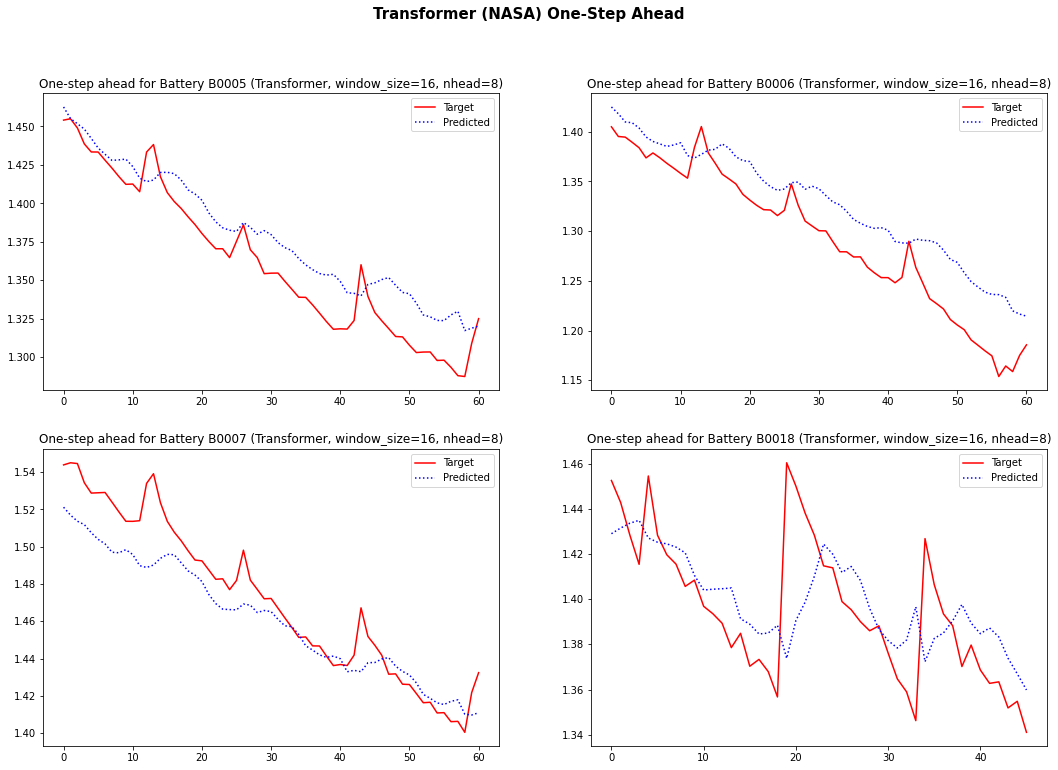

In [ ]:
test_sequence, test_labels = {}, {}
X_test, y_test = {}, {}
plt.figure(figsize=(18,12))
plt.suptitle('Transformer (NASA) One-Step Ahead',fontsize=15, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list))):
  # Generate test tensor
  X_test[leave_out], y_test[leave_out], test_sequence[leave_out], test_labels[leave_out] = create_test_tensor(Battery,
                                                                      leave_out=[leave_out],
                                                                      window_size=window_size,
                                                                      test_split = 0.6)
  # Send to device
  X_test[leave_out], y_test[leave_out] = X_test[leave_out].to(device), y_test[leave_out].to(device)

  model[leave_out].eval()
  acc = 0
  pred = []

  with torch.inference_mode():
    for test_tensor, label in zip(X_test[leave_out], y_test[leave_out]):
      preds, _ = model[leave_out]((test_tensor/Rated_Capacity).reshape(-1,1,window_size))
      pred.append(preds)
      acc += accuracy(preds*Rated_Capacity, label)

  #pred = torch.cat(pred)
  pred = torch.tensor(pred) * Rated_Capacity
  acc = acc/len(y_test) * 100
  mae = mean_absolute_error(y_test[leave_out].cpu(),pred.cpu())
  rmse = mean_squared_error(y_test[leave_out].cpu(),pred.cpu())
  print(f"Accuracy on Test Data {leave_out}: {acc:.5f}%\nMAE: {mae:.5f}\nRMSE: {rmse:.5f}\n{'-'*64}")

  plt.subplot(2,2,idx+1)
  plt.plot(y_test[leave_out].cpu(),'r-',label="Target")
  plt.plot(pred.cpu(),'b:',label="Predicted")
  plt.title(f"One-step ahead for Battery {leave_out} (Transformer, window_size={window_size}, nhead={nhead})")
  plt.legend()

# Save test tensor
torch.save((X_test, y_test, test_sequence, test_labels), f'test_tensors_Transformer_NASA.pt')

#### Iterative Multi-step Ahead Prediction

In [ ]:
def plot_predictions(train_cap, train_cyc, label_cap, label_cyc, predictions, title):
  plt.title(title)
  plt.plot(train_cyc, train_cap, 'k-', label='Input data')
  plt.plot(label_cyc, label_cap, 'k:', label='Target')
  plt.plot(label_cyc, predictions, 'b-', label='Predicted')
  plt.legend()
  plt.xlabel('Number of Discharge Cycles')
  plt.ylabel('Capacity (in Ah)')

accuracy for B0005: 97.46751% | MAE: 0.0351 | RMSE: 0.0374
accuracy for B0006: 96.10465% | MAE: 0.0501 | RMSE: 0.0546
accuracy for B0007: 98.89378% | MAE: 0.0162 | RMSE: 0.0206
accuracy for B0018: 98.01113% | MAE: 0.0281 | RMSE: 0.0317


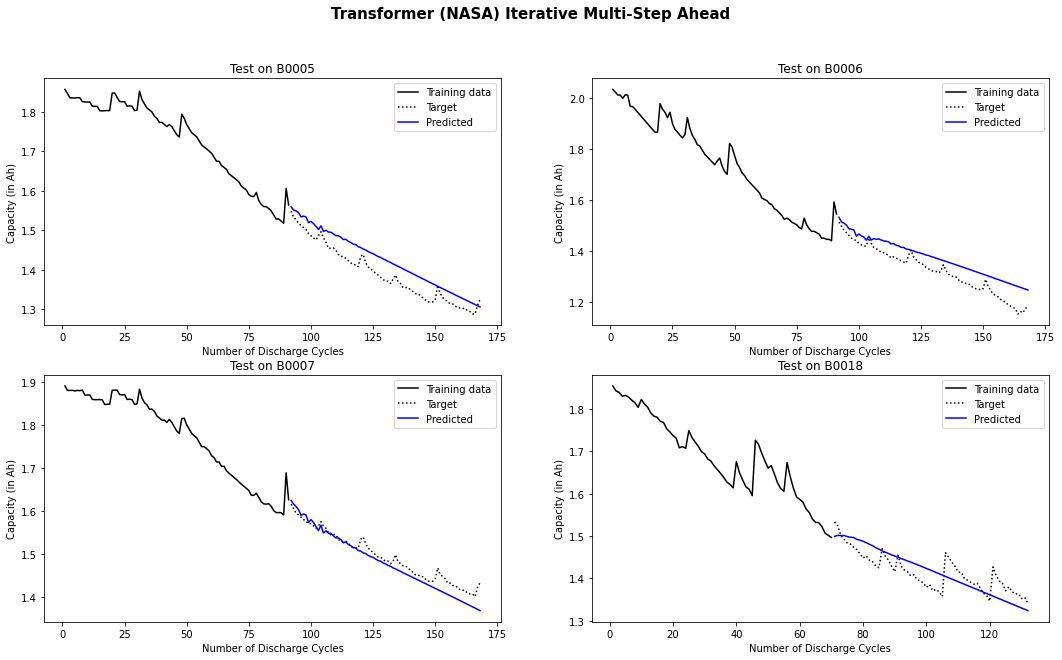

In [ ]:
plt.figure(figsize=(18,10))
plt.suptitle('Transformer (NASA) Iterative Multi-Step Ahead',fontsize=15, weight='bold')

for leave_out, idx in zip(Battery_list, range(len(Battery_list)) ):
  eval_cap, eval_cyc = test_sequence[leave_out]
  test_cap, test_cyc = test_labels[leave_out]

  # convert lists to tensors
  eval_cap, eval_cyc = eval_cap, eval_cyc
  test_cap, test_cyc = np.array(test_cap), np.array(test_cyc)

  # create point list which contains predictions
  preds = []
  # sequence which contains prediction inputs (last window_size entries of array)
  seq = eval_cap[-window_size:]

  model[leave_out].eval()
  with torch.inference_mode():
    for j in range(len(test_cap)):
      pred, _ = model[leave_out](torch.tensor(seq, dtype=torch.float32, device=device).reshape(-1,1,window_size)/Rated_Capacity)
      seq = seq[1:]
      seq.append(np.float64(pred * Rated_Capacity))
      preds.append(np.float64(pred * Rated_Capacity))

  # copy preds to dictionary
  preds = np.array(preds)

  # plot predictions
  plt.subplot(2,2,idx+1)
  plot_predictions(train_cap = eval_cap,
                    train_cyc = eval_cyc,
                    label_cap = test_cap,
                    label_cyc = test_cyc,
                    predictions = preds,
                    title = f"Test on {leave_out}")

  # Print accuracy
  error = np.abs(preds - test_cap)/test_cap
  acc = np.ones_like(error)- error
  acc = np.sum(acc)/len(test_cap)*100
  mae = mean_absolute_error(test_cap,preds)
  rmse = sqrt(mean_squared_error(test_cap,preds))
  print(f"accuracy for {leave_out}: {acc:.5f}% | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

## Plot predicted vs actual 

In [ ]:
_, _, train_data_06, test_data_06 = get_train_test(Battery, 'B0018', window_size=window_size)
test_x = train_data_06.copy()
y_06 = []
point_list = []
model.eval()
with torch.inference_mode():
    while (len(test_x) - len(train_data_06)) < len(test_data_06):
        x = np.reshape(np.array(test_x[-window_size:])/Rated_Capacity,(-1, 1, window_size)).astype(np.float32)
        x = torch.from_numpy(x).to(device)
        pred, _ = model(x)
        next_point = pred.data.cpu().numpy()[0, 0] * Rated_Capacity
        test_x.append(next_point)
        point_list.append(next_point)
    y_06.append(point_list)
y_predicted = [train_data_06 + y_06[-1]]
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
c = 0
df_result = Battery['B0018']
ax.plot(df_result[0], df_result[1], 'b', label='Actual')
ax.plot(df_result[0], y_predicted[-1], 'g--', label='Predicted')
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Actual vs Predicted Capacity Values')
plt.legend()

###  use grid-search to determ parameters

In [ ]:
Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 2000
nhead = 8
is_load_weights = False

weight_decay = 0.0
noise_level = 0.0
alpha = 0.0
metric = 're'

states = {}
for lr in [1e-3, 1e-2]:
    for num_layers in [1, 2]:
        for hidden_dim in [16, 32]:
            for alpha in [1e-5, 1e-4]:
                show_str = 'lr={}, num_layers={}, hidden_dim={}, alpha={}'.format(lr, num_layers, hidden_dim, alpha)
                print(show_str)
                SCORE = []
                for seed in range(5):
                    print('seed:{}'.format(seed))
                    score_list, _ = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, 
                                          weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                                          noise_level=noise_level, metric=metric, is_load_weights=is_load_weights)
                    print(np.array(score_list))
                    print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
                    print('------------------------------------------------------------------')
                    for s in score_list:
                        SCORE.append(s)

                print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
                states[show_str] = np.mean(np.array(SCORE))
                print('===================================================================')

min_key = min(states, key = states.get)
print('optimal parameters: {}, result: {}'.format(min_key, states[min_key]))

##Printing Model Summary

In [ ]:
!zip -r checkpoints_Transformer_NASA.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/transformer_NASA_B0018.pth (deflated 44%)
  adding: checkpoints/transformer_NASA_B0006.pth (deflated 44%)
  adding: checkpoints/transformer_NASA_B0007.pth (deflated 45%)
  adding: checkpoints/transformer_NASA_B0005.pth (deflated 45%)


In [ ]:
from torchinfo import summary
summary(model,input_size=(7,1,16),device='cuda')

Layer (type:depth-idx)                        Output Shape              Param #
Net                                           [7, 1]                    --
├─Autoencoder: 1-1                            [7, 8]                    --
│    └─Linear: 2-1                            [7, 8]                    136
│    └─Linear: 2-2                            [7, 16]                   144
├─PositionalEncoding: 1-2                     [7, 1, 8]                 --
├─TransformerEncoder: 1-3                     [1, 7, 8]                 --
│    └─ModuleList: 2-3                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 7, 8]                 872
│    │    └─TransformerEncoderLayer: 3-2      [1, 7, 8]                 872
├─Linear: 1-4                                 [7, 1]                    9
Total params: 2,033
Trainable params: 2,033
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (

In [ ]:
model(torch.rand(1,1,16).to(device))

(tensor([[0.5777]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.6923, 0.6519, 0.5738, 0.5798, 0.5953, 0.5640, 0.6047, 0.5822, 0.4985,
          0.5176, 0.5888, 0.6034, 0.6408, 0.6308, 0.5719, 0.5880]],
        device='cuda:0', grad_fn=<AddmmBackward0>))

## Old training loop

In [ ]:
def train(lr=0.01, feature_size=8, hidden_dim=32, num_layers=1, nhead=8, weight_decay=0.0, EPOCH=1000, seed=0, 
         alpha=0.0, noise_level=0.0, dropout=0.0, metric='re', is_load_weights=True):
    score_list, result_list = [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        window_size = feature_size
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        # print('sample size: {}'.format(train_size))

        model = Net(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, dropout=dropout,
                    noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()     
        
        # load the weights if true
        if is_load_weights:
          model.load_state_dict(torch.load('transformer_NASA.pth')) 

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        rmse, re = 1, 1
        score_, score = [1],[1]
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32) # (batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)          # (batch_size, 1)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output, decode = model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, X.reshape(-1, feature_size))
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy() 
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)   # shape (batch_size,feature_size=1,input_size)
                    pred, _ = model(x)                   # pred shape: (batch_size=1, feature_size=1)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
                    point_list.append(next_point)  # Saves the predicted value of the last point in the output sequence
                y_.append(point_list)              # Save all the predicted values

                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))
            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 1e-4) and (score_[0] < score[0]) and (re < 0.2):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list, y_, model, test_data

In [ ]:
Rated_Capacity = 2.0
window_size = 16
feature_size = window_size
dropout = 0.0
EPOCH = 500
nhead = 8
hidden_dim = 32
num_layers = 2
lr = 0.01    # learning rate
weight_decay = 0.0
noise_level = 0.0
alpha = 0.0001
is_load_weights = True
metric = 'rmse'
seed = 0

SCORE = []
print('seed:{}'.format(seed))
score_list, result_list, y_data, model, test_data = train(lr=lr, feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, nhead=nhead, 
                                                      weight_decay=weight_decay, EPOCH=EPOCH, seed=seed, dropout=dropout, alpha=alpha, 
                                                      noise_level=noise_level, metric=metric, is_load_weights=is_load_weights)
print(np.array(score_list))
for s in score_list:
    SCORE.append(s)
print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
torch.save(model.state_dict(), 'transformer_NASA.pth')

seed:0
epoch:9  | loss:0.0077 | RMSE:0.2186 | RE:1.0000
epoch:19 | loss:0.0081 | RMSE:0.1907 | RE:1.0000
epoch:29 | loss:0.0079 | RMSE:0.1831 | RE:1.0000
epoch:39 | loss:0.0078 | RMSE:0.1788 | RE:1.0000
epoch:49 | loss:0.0077 | RMSE:0.1793 | RE:1.0000
epoch:59 | loss:0.0076 | RMSE:0.1784 | RE:1.0000
epoch:69 | loss:0.0074 | RMSE:0.1790 | RE:1.0000
epoch:79 | loss:0.0072 | RMSE:0.1780 | RE:1.0000
epoch:89 | loss:0.0069 | RMSE:0.1779 | RE:1.0000
epoch:99 | loss:0.0062 | RMSE:0.1767 | RE:1.0000
epoch:109 | loss:0.0044 | RMSE:0.1729 | RE:1.0000
epoch:119 | loss:0.0004 | RMSE:0.0604 | RE:0.0094
epoch:129 | loss:0.0005 | RMSE:0.1692 | RE:1.0000
epoch:139 | loss:0.0002 | RMSE:0.0946 | RE:0.0849
epoch:149 | loss:0.0002 | RMSE:0.0780 | RE:0.1887
epoch:159 | loss:0.0002 | RMSE:0.0788 | RE:0.1226
epoch:169 | loss:0.0002 | RMSE:0.0798 | RE:0.1226
epoch:179 | loss:0.0002 | RMSE:0.0836 | RE:0.1604
epoch:189 | loss:0.0002 | RMSE:0.0745 | RE:0.1132
epoch:199 | loss:0.0002 | RMSE:0.0782 | RE:0.1321
epo

In [ ]:
threshold = 0.7;
cycles_left = 0;

for i in range(len(result_list)):
  if result_list[i][1] >= threshold * Rated_Capacity:
    cycles_left += 1
  else:
    break

print("Cycles left: "+str(cycles_left)+"\nTotal Cycles: "+str(len(result_list[1])))

Cycles left: 4
Total Cycles: 151


In [ ]:
test_data_tensor = np.reshape(np.array(test_data[0:112]), (-1, 1, feature_size)).astype(np.float32)
print(f"test_data_tensor shape: {test_data_tensor.shape}")
test_data_tensor = torch.Tensor(test_data_tensor).to(device)
print(f"test_data_tensor shape: {test_data_tensor.shape}")
print("\nSaving test_data_tensor...")
torch.save(test_data_tensor.cpu(), 'test_data_tensor.pt')
print("Done.")

test_data_tensor shape: (7, 1, 16)
test_data_tensor shape: torch.Size([7, 1, 16])

Saving test_data_tensor...
Done.
